# 02. Integration of i-VSNs and VSGOs

Following procedure includes integration of 10 i-VSNs and VSGOs. 

The data can be downloaded from GEO accession GSE264303. 

     GSM8215758	Visceral Sensory Ganglion Organoid(VSGO), fresh, E3, spheroid, day32, snRANseq 
     GSM8215759	Visceral Sensory Ganglion Organoid(VSGO), frozen, E3, spheroid, day33, snRNAseq
     GSM8215760	induced Visceral Sensory Neurons(i-VSN), frozen, E3, monolayer, day40, snRNAseq
     GSM8215761	Visceral Sensory Ganglion Organoid(VSGO), fresh, E4, spheroid, day32, snRANseq
     GSM8215762	Visceral Sensory Ganglion Organoid(VSGO), frozen, E4, spheroid, day33, snRNAseq
     GSM8215763	induced Visceral Sensory Neurons(i-VSN), frozen, E4, monolayer, day40, snRNAseq
     GSM8215764	induced Visceral Sensory Neurons(i-VSN), fresh, E3, monolayer, day19, scRNAseq
     GSM8215765	induced Visceral Sensory Neurons(i-VSN), fresh, E3, monolayer, day24, scRNAseq
     GSM8215766	induced Visceral Sensory Neurons(i-VSN), fresh, E3, monolayer, day32, scRNAseq
     GSM8215767	induced Visceral Sensory Neurons(i-VSN), fresh, E3, monolayer, day42, scRNAseq

If you have any questions, please contact hwee38@snu.ac.kr


In [1]:
import scanpy as sc
import pandas as pd
import scvi
import h5py
import anndata
import tables
import numpy as np
import scipy.sparse as sp
from typing import Dict
import torch
import matplotlib.pyplot as plt
import seaborn as sns
#from matplotlib.colors import ListedColormap
from matplotlib.pyplot import rc_context
#sc.set_figure_params(dpi=300, facecolor='white')
sc.set_figure_params(dpi=80, dpi_save=600, transparent=True)
#%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams
import warnings
warnings.simplefilter("ignore", category=UserWarning)
warnings.simplefilter("ignore", category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [2]:
# scRNA
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()

scanpy==1.9.8 anndata==0.10.5.post1 umap==0.5.5 numpy==1.26.4 scipy==1.11.4 pandas==2.2.0 scikit-learn==1.4.1.post1 statsmodels==0.14.1 igraph==0.11.4 pynndescent==0.5.11


In [3]:
scvi.__version__

'1.1.1'

In [4]:
torch.__version__

'2.0.1+cu117'

In [5]:
torch.cuda.is_available()

True

In [6]:
def anndata_from_h5(file: str,
                    analyzed_barcodes_only: bool = True) -> 'anndata.AnnData':
    """Load an output h5 file into an AnnData object for downstream work.

    Args:
        file: The h5 file
        analyzed_barcodes_only: False to load all barcodes, so that the size of
            the AnnData object will match the size of the input raw count matrix.
            True to load a limited set of barcodes: only those analyzed by the
            algorithm. This allows relevant latent variables to be loaded
            properly into adata.obs and adata.obsm, rather than adata.uns.

    Returns:
        adata: The anndata object, populated with inferred latent variables
            and metadata.

    """

    d = dict_from_h5(file)
    X = sp.csc_matrix((d.pop('data'), d.pop('indices'), d.pop('indptr')),
                      shape=d.pop('shape')).transpose().tocsr()

    # check and see if we have barcode index annotations, and if the file is filtered
    barcode_key = [k for k in d.keys() if (('barcode' in k) and ('ind' in k))]
    if len(barcode_key) > 0:
        max_barcode_ind = d[barcode_key[0]].max()
        filtered_file = (max_barcode_ind >= X.shape[0])
    else:
        filtered_file = True

    if analyzed_barcodes_only:
        if filtered_file:
            # filtered file being read, so we don't need to subset
            print('Assuming we are loading a "filtered" file that contains only cells.')
            pass
        elif 'barcode_indices_for_latents' in d.keys():
            X = X[d['barcode_indices_for_latents'], :]
            d['barcodes'] = d['barcodes'][d['barcode_indices_for_latents']]
        elif 'barcodes_analyzed_inds' in d.keys():
            X = X[d['barcodes_analyzed_inds'], :]
            d['barcodes'] = d['barcodes'][d['barcodes_analyzed_inds']]
        else:
            print('Warning: analyzed_barcodes_only=True, but the key '
                  '"barcodes_analyzed_inds" or "barcode_indices_for_latents" '
                  'is missing from the h5 file. '
                  'Will output all barcodes, and proceed as if '
                  'analyzed_barcodes_only=False')

    # Construct the anndata object.
    adata = anndata.AnnData(X=X,
                            obs={'barcode': d.pop('barcodes').astype(str)},
                            var={'gene_name': (d.pop('gene_names') if 'gene_names' in d.keys()
                                               else d.pop('name')).astype(str)},
                            dtype=X.dtype)
    adata.obs.set_index('barcode', inplace=True)
    adata.var.set_index('gene_name', inplace=True)

    # For CellRanger v2 legacy format, "gene_ids" was called "genes"... rename this
    if 'genes' in d.keys():
        d['id'] = d.pop('genes')

    # For purely aesthetic purposes, rename "id" to "gene_id"
    if 'id' in d.keys():
        d['gene_id'] = d.pop('id')

    # If genomes are empty, try to guess them based on gene_id
    if 'genome' in d.keys():
        if np.array([s.decode() == '' for s in d['genome']]).all():
            if '_' in d['gene_id'][0].decode():
                print('Genome field blank, so attempting to guess genomes based on gene_id prefixes')
                d['genome'] = np.array([s.decode().split('_')[0] for s in d['gene_id']], dtype=str)

    # Add other information to the anndata object in the appropriate slot.
    _fill_adata_slots_automatically(adata, d)

    # Add a special additional field to .var if it exists.
    if 'features_analyzed_inds' in adata.uns.keys():
        adata.var['cellbender_analyzed'] = [True if (i in adata.uns['features_analyzed_inds'])
                                            else False for i in range(adata.shape[1])]

    if analyzed_barcodes_only:
        for col in adata.obs.columns[adata.obs.columns.str.startswith('barcodes_analyzed')
                                     | adata.obs.columns.str.startswith('barcode_indices')]:
            try:
                del adata.obs[col]
            except Exception:
                pass
    else:
        # Add a special additional field to .obs if all barcodes are included.
        if 'barcodes_analyzed_inds' in adata.uns.keys():
            adata.obs['cellbender_analyzed'] = [True if (i in adata.uns['barcodes_analyzed_inds'])
                                                else False for i in range(adata.shape[0])]

    return adata


def dict_from_h5(file: str) -> Dict[str, np.ndarray]:
    """Read in everything from an h5 file and put into a dictionary."""
    d = {}
    with tables.open_file(file) as f:
        # read in everything
        for array in f.walk_nodes("/", "Array"):
            d[array.name] = array.read()
    return d


def _fill_adata_slots_automatically(adata, d):
    """Add other information to the adata object in the appropriate slot."""

    for key, value in d.items():
        try:
            if value is None:
                continue
            value = np.asarray(value)
            if len(value.shape) == 0:
                adata.uns[key] = value
            elif value.shape[0] == adata.shape[0]:
                if (len(value.shape) < 2) or (value.shape[1] < 2):
                    adata.obs[key] = value
                else:
                    adata.obsm[key] = value
            elif value.shape[0] == adata.shape[1]:
                if value.dtype.name.startswith('bytes'):
                    adata.var[key] = value.astype(str)
                else:
                    adata.var[key] = value
            else:
                adata.uns[key] = value
        except Exception:
            print('Unable to load data into AnnData: ', key, value, type(value))

In [7]:
import anndata as ad
import pandas as pd

# Base directory and common file path
base_dir = 'your/path/'

# Specific file names and metadata
files_metadata = [
    ('cellbender_VSN_E3_spheroid_fresh_filtered.h5', 'E3_VSGO_fresh_day32', 'VSGO', 'sample3', 'Spheroid', 'Fresh', 'E3', 'snRNA', '32', 'GSM8215758_QC_DF.csv'),
    ('cellbender_VSN_E3_spheroid_frozen_filtered.h5', 'E3_VSGO_frozen_day33', 'VSGO', 'sample4', 'Spheroid', 'Frozen', 'E3', 'snRNA', '33', 'GSM8215759_QC_DF.csv'),
    ('cellbender_VSN_E3_monolayer_frozen_filtered.h5', 'E3_iVSN_frozen_day40', 'iVSN', 'sample5', 'Monolayer', 'Frozen', 'E3', 'snRNA', '40', 'GSM8215760_QC_DF.csv'),
    ('cellbender_VSN_E4_spheroid_fresh_filtered.h5', 'E4_VSGO_fresh_day32', 'VSGO', 'sample6', 'Spheroid', 'Fresh', 'E4', 'snRNA', '32', 'GSM8215761_QC_DF.csv'),
    ('cellbender_VSN_E4_spheroid_frozen_filtered.h5', 'E4_VSGO_frozen_day33', 'VSGO', 'sample7', 'Spheroid', 'Frozen', 'E4', 'snRNA', '33', 'GSM8215762_QC_DF.csv'),
    ('cellbender_VSN_E4_monolayer_frozen_filtered.h5', 'E4_iVSN_frozen_day40', 'iVSN', 'sample8', 'Monolayer', 'Frozen', 'E4', 'snRNA', '40', 'GSM8215763_QC_DF.csv'),
    ('cellbender_VSN_sc_day19_filtered.h5', 'iVSN_scRNA_E3_day19', 'iVSN', 'sample9', 'Monolayer', 'Fresh', 'E3', 'scRNA', '19', 'GSM8215764_QC_DF.csv'),
    ('cellbender_VSN_sc_day24_filtered.h5', 'iVSN_scRNA_E3_day24', 'iVSN', 'sample10', 'Monolayer', 'Fresh', 'E3', 'scRNA', '24', 'GSM8215765_QC_DF.csv'),
    ('cellbender_VSN_sc_day32_filtered.h5', 'iVSN_scRNA_E3_day32', 'iVSN', 'sample11', 'Monolayer', 'Fresh', 'E3', 'scRNA', '32', 'GSM8215766_QC_DF.csv'),
    ('cellbender_VSN_sc_day42_filtered.h5', 'iVSN_scRNA_E3_day42', 'iVSN', 'sample12', 'Monolayer', 'Fresh', 'E3', 'scRNA', '42', 'GSM8215767_QC_DF.csv')
]

# Function to load AnnData object from H5 file
#def anndata_from_h5(file_path):
#    return anndata_from_h5(file_path)

# Load AnnData objects, map with CSV data, set metadata, and ensure unique names
adatas = []
for file_name, file, sample, sample2, state, state2, type1, method, day, csv_filename in files_metadata:
    # Load AnnData object
    file_path = f"{base_dir}{file_name}"
    adata = anndata_from_h5(file_path)
    
    # Read the corresponding CSV file into a DataFrame
    df = pd.read_csv(csv_filename)
    
    # Convert the DataFrame back to a dictionary
    identifyD = dict(zip(df['Barcode'], df['Label']))
    
    # Map the dictionary to the AnnData object to add the 'doublet' information
    adata.obs['doublet'] = adata.obs.index.map(identifyD)
    adata = adata[adata.obs['doublet'].isin(['singlet'])]
    
    # Ensure unique names
    adata.obs_names_make_unique()
    adata.var_names_make_unique()
    
    # Set metadata
    adata.obs['file'] = file
    adata.obs['Sample'] = sample
    adata.obs['Sample2'] = sample2
    adata.obs['state'] = state
    adata.obs['state2'] = state2
    adata.obs['type1'] = type1
    adata.obs['method'] = method
    adata.obs['day'] = day
    
    # Append the AnnData object to the list
    adatas.append(adata)

# Concatenate the AnnData objects
adata = ad.concat(adatas, join='outer', uns_merge='unique', index_unique=None)

# Ensure the combined AnnData object has unique observation names
adata.obs_names_make_unique()

# Display the result
print(adata)


Assuming we are loading a "filtered" file that contains only cells.
Assuming we are loading a "filtered" file that contains only cells.
Assuming we are loading a "filtered" file that contains only cells.
Assuming we are loading a "filtered" file that contains only cells.
Assuming we are loading a "filtered" file that contains only cells.
Assuming we are loading a "filtered" file that contains only cells.
Assuming we are loading a "filtered" file that contains only cells.
Assuming we are loading a "filtered" file that contains only cells.
Assuming we are loading a "filtered" file that contains only cells.
Assuming we are loading a "filtered" file that contains only cells.
AnnData object with n_obs × n_vars = 32171 × 38606
    obs: 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'doublet', 'file', 'Sample', 'Sample2', 'state', 'state2', 'type1', 'method', 'day'
    uns: 'fraction_data_used_for_testing', 'target_false_positive_rate', 'test_epoch'
    obsm: 'latent_gene_

In [8]:
adata.obs['file'].value_counts()

file
E3_VSGO_frozen_day33    6125
E4_VSGO_fresh_day32     5899
E3_VSGO_fresh_day32     5203
E4_VSGO_frozen_day33    4829
iVSN_scRNA_E3_day32     2167
iVSN_scRNA_E3_day24     2042
iVSN_scRNA_E3_day19     1888
E3_iVSN_frozen_day40    1403
E4_iVSN_frozen_day40    1364
iVSN_scRNA_E3_day42     1251
Name: count, dtype: int64

filtered out 2545 genes that are detected in less than 1 cells


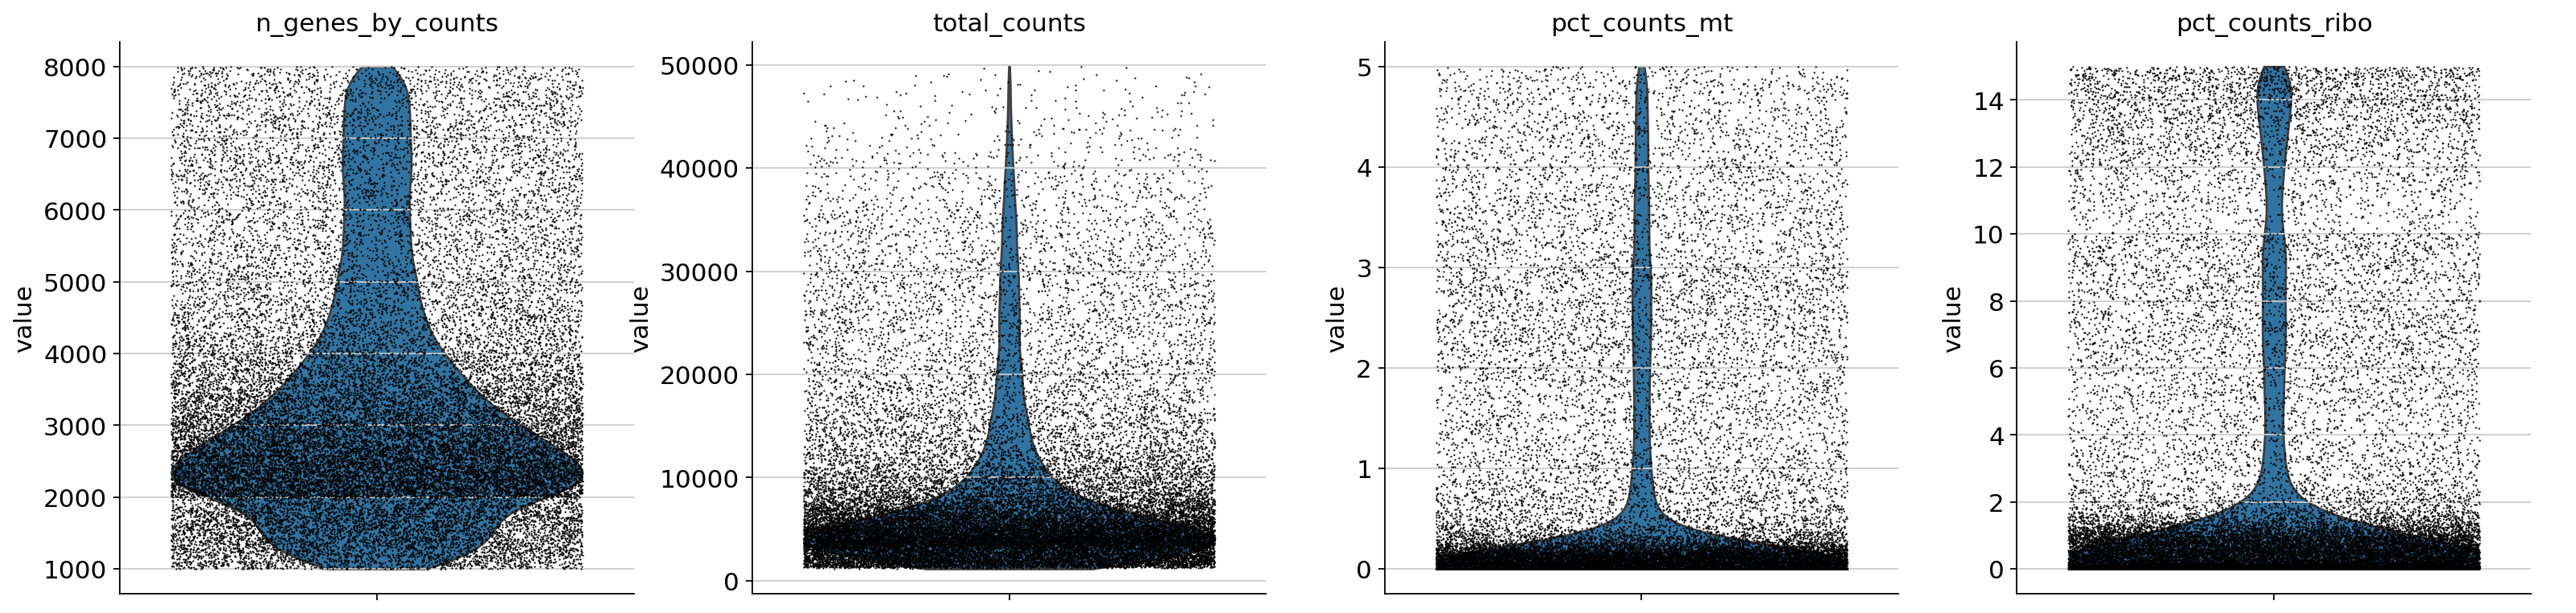

In [9]:
#pp
sc.pp.filter_cells(adata, min_genes = 200)
sc.pp.filter_genes(adata, min_cells = 1)
ribo_url = "http://software.broadinstitute.org/gsea/msigdb/download_geneset.jsp?geneSetName=KEGG_RIBOSOME&fileType=txt"
ribo_genes = pd.read_table(ribo_url, skiprows=2, header = None)
#ribo_genes
adata.var['ribo'] = adata.var_names.isin(ribo_genes[0].values)
sc.pp.filter_genes(adata, min_cells = 1)
adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars = ['mt','ribo'], percent_top = None, log1p = False, inplace = True)
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo'], 
             jitter=0.4, multi_panel=True)

In [10]:
adata.layers['counts'] = adata.X.copy() 
sc.pp.normalize_total(adata, target_sum = 1e4) 
sc.pp.log1p(adata)
adata.layers['log1p'] = adata.X.copy()
adata.raw = adata
adata
# Optional for UMAP visulalizing
# import scanpy.external as sce
# sce.pp.magic(adata, name_list='all_genes', knn=5, random_state =100)
# adata.layers['MAGIC'] = adata.X.copy() 
# adata.X = adata.layers['log1p'].copy() #Revert to log1p from MAGIC. For general visualization or DEG analysis. 


normalizing counts per cell
    finished (0:00:01)


AnnData object with n_obs × n_vars = 32171 × 36061
    obs: 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'doublet', 'file', 'Sample', 'Sample2', 'state', 'state2', 'type1', 'method', 'day', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'n_cells', 'ribo', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'fraction_data_used_for_testing', 'target_false_positive_rate', 'test_epoch', 'log1p'
    obsm: 'latent_gene_encoding'
    layers: 'counts', 'log1p'

In [11]:
# Summary statistics per file/batch
df = adata.obs[['n_genes_by_counts','total_counts','file']]
df_all = pd.DataFrame(index=df['file'].unique())

df_all['mean_genes']=df.groupby(by='file')['n_genes_by_counts'].mean()
df_all['median_genes']=df.groupby(by='file')['n_genes_by_counts'].median()
df_all['mean_counts']=df.groupby(by='file')['total_counts'].mean()
df_all['median_counts']=df.groupby(by='file')['total_counts'].median()
df_all['n_cells']=df['file'].value_counts()
df_all.astype('float').round(1)

,mean_genes,median_genes,mean_counts,median_counts,n_cells
E3_VSGO_fresh_day32,2271.8,1972.0,4287.8,3075.0,5203.0
E3_VSGO_frozen_day33,3168.5,2895.0,6736.2,5678.0,6125.0
E3_iVSN_frozen_day40,3454.6,3066.0,7747.7,6136.0,1403.0
E4_VSGO_fresh_day32,2256.4,1883.0,3995.4,2801.0,5899.0
E4_VSGO_frozen_day33,3256.8,2896.0,6709.9,5387.0,4829.0
E4_iVSN_frozen_day40,3391.7,2969.0,7627.4,5828.0,1364.0
iVSN_scRNA_E3_day19,5398.9,5543.5,19916.5,18715.5,1888.0
iVSN_scRNA_E3_day24,4872.6,5008.5,17693.4,14637.0,2042.0
iVSN_scRNA_E3_day32,5006.5,5489.0,18727.7,17408.0,2167.0
iVSN_scRNA_E3_day42,5469.9,5996.0,20956.1,21117.0,1251.0


# Cell-Cycle scoring

97
calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    430 total control genes are used. (0:00:03)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    430 total control genes are used. (0:00:03)
-->     'phase', cell cycle phase (adata.obs)


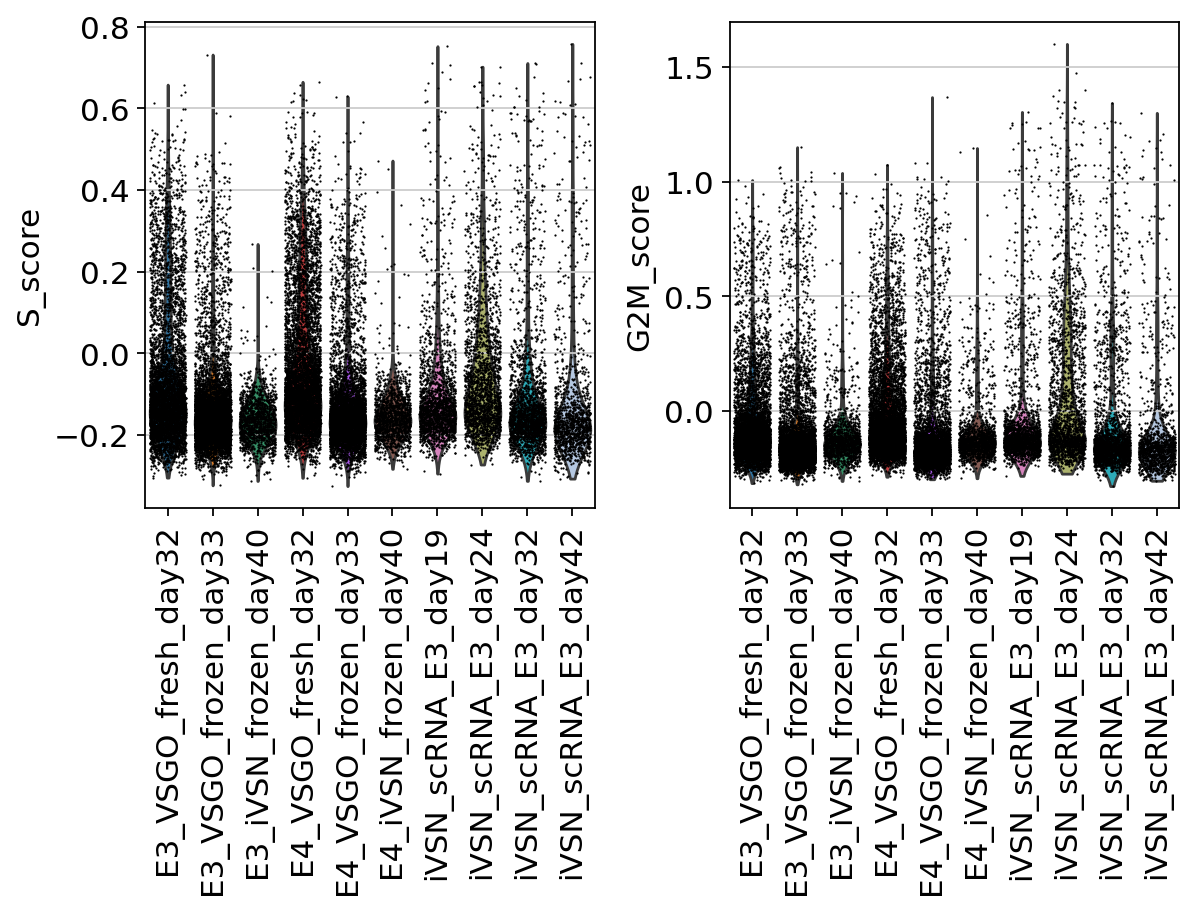

In [12]:
#https://nbviewer.org/github/theislab/scanpy_usage/blob/master/180209_cell_cycle/cell_cycle.ipynb
cell_cycle_genes = [x.strip() for x in open('./regev_lab_cell_cycle_genes.txt')]
print(len(cell_cycle_genes))

# Split into 2 lists
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]

cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]
#print(len(cell_cycle_genes))
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)
sc.pl.violin(adata, ['S_score', 'G2M_score'],
             jitter=0.4, groupby = 'file', rotation=90)

computing PCA
    with n_comps=50
    finished (0:00:03)


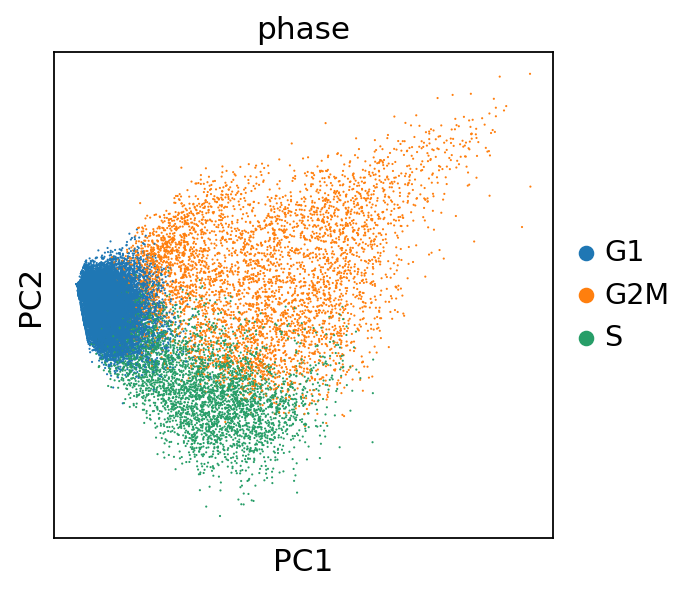

In [13]:
adata_cc_genes = adata[:, cell_cycle_genes]
sc.tl.pca(adata_cc_genes)
sc.pl.pca_scatter(adata_cc_genes, color='phase')

In [14]:
sc.pp.highly_variable_genes(adata, n_top_genes=5000, subset = True, layer = 'counts',
                           flavor = "seurat_v3", batch_key="file") #no batch_key if one sample

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


highly_variable_nbatches
1     1068
10    1011
9      524
2      441
3      368
4      336
8      331
5      317
7      305
6      299
Name: count, dtype: int64

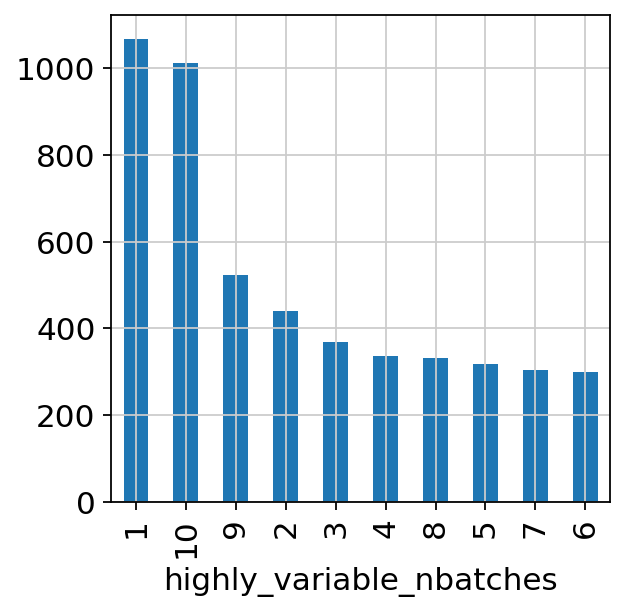

In [15]:
n_batches = adata.var["highly_variable_nbatches"].value_counts()
ax = n_batches.plot(kind="bar")
n_batches

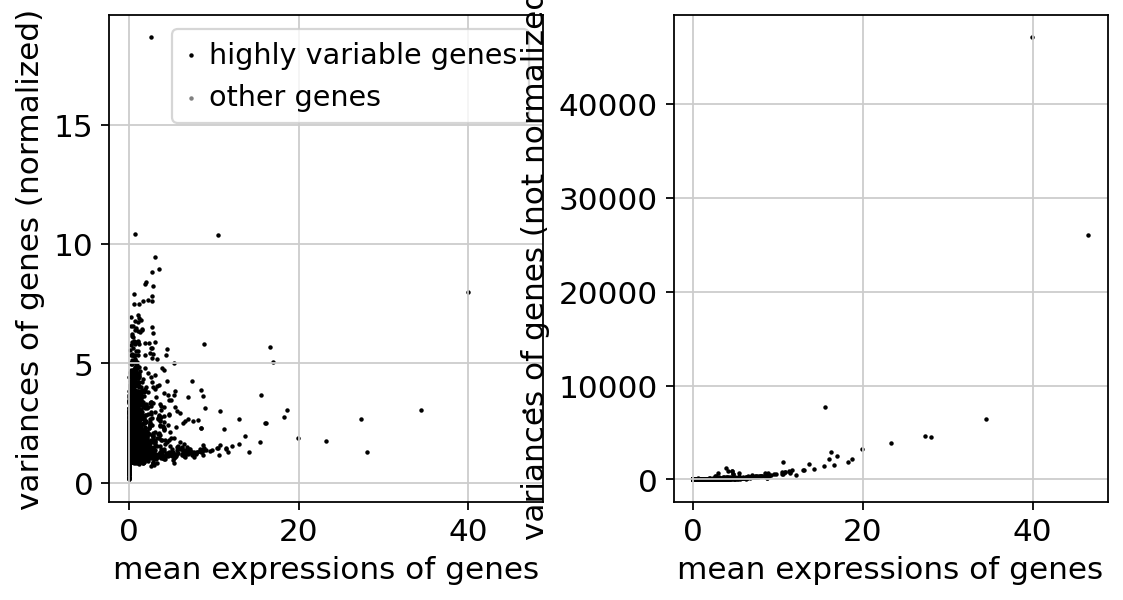

In [16]:
sc.pl.highly_variable_genes(adata)#, log=True)

In [17]:
scvi.model.SCVI.setup_anndata(adata, layer = "counts",
                              batch_key='file',
                             categorical_covariate_keys=['file', 'Sample', 'state', 'state2', 'type1', 'method', 'day'],
                             continuous_covariate_keys=['pct_counts_mt', 'total_counts', 'n_genes_by_counts'])

#get rid of categorical_covariate_keys if only one sample

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [18]:
model = scvi.model.SCVI(adata, n_hidden=256, n_layers =2, n_latent=50, gene_likelihood="zinb", dropout_rate=0.25)
model

SCVI model with the following parameters: 
n_hidden: 256, n_latent: 50, n_layers: 2, dropout_rate: 0.25, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal.
Training status: Not Trained
Model's adata is minified?: False

In [19]:
model.view_anndata_setup()

Anndata setup with scvi-tools version 1.1.1.

Setup via `SCVI.setup_anndata` with arguments:

{
│   'layer': 'counts',
│   'batch_key': 'file',
│   'labels_key': None,
│   'size_factor_key': None,
│   'categorical_covariate_keys': ['file', 'Sample', 'state', 'state2', 'type1', 'method', 'day'],
│   'continuous_covariate_keys': ['pct_counts_mt', 'total_counts', 'n_genes_by_counts']
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │  10   │
│         n_cells          │ 32171 │
│ n_extra_categorical_covs │   7   │
│ n_extra_continuous_covs  │   3   │
│         n_labels         │   1   │
│          n_vars          │ 5000  │
└──────────────────────────┴───────┘

                             Data Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Registry Key      ┃            scvi-tools Location             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X            │           adata.layers['counts']           │
│         batch          │          adata.obs['_scvi_batch']          │
│ extra_categorical_covs │ adata.obsm['_scvi_extra_categorical_covs'] │
│ extra_continuous_covs  │ adata.obsm['_scvi_extra_continuous_covs']  │
│         labels         │         adata.obs['_scvi_labels']          │
└────────────────────────┴────────────────────────────────────────────┘

                       batch State Registry                       
┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃  Source Location  ┃      Categories      ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['file'] │ E3_VSGO_fresh_day32  │          0          │
│                   │ E3_VSGO_frozen_day33 │          1          │
│                   │ E3_iVSN_frozen_day40 │          2          │
│                   │ E4_VSGO_fresh_day32  │          3          │
│                   │ E4_VSGO_frozen_day33 │          4          │
│                   │ E4_iVSN_frozen_day40 │          5          │
│                   │ iVSN_scRNA_E3_day19  │          6          │
│                   │ iVSN_scRNA_E3_day24  │          7          │
│                   │ iVSN_scRNA_E3_day32  │          8          │
│                   │ iVSN_scRNA_E3_day42  │          9          │
└───────────────────┴──────────────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

               extra_categorical_covs State Registry                
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃      Categories      ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['Sample'] │         VSGO         │          0          │
│                     │         iVSN         │          1          │
│                     │                      │                     │
│  adata.obs['day']   │          19          │          0          │
│                     │          24          │          1          │
│                     │          32          │          2          │
│                     │          33          │          3          │
│                     │          40          │          4          │
│                     │          42          │          5          │
│                     │                      │                     │
│  adata.obs['file']  │ E3_VSGO_fresh_day32  │          0          │
│                     │ E3_VSGO_frozen_day33 │          1          │
│                     │ E3_iVSN_frozen_day40 │          2          │
│                     │ E4_VSGO_fresh_day32  │          3          │
│                     │ E4_VSGO_frozen_day33 │          4          │
│                     │ E4_iVSN_frozen_day40 │          5          │
│                     │ iVSN_scRNA_E3_day19  │          6          │
│                     │ iVSN_scRNA_E3_day24  │          7          │
│                     │ iVSN_scRNA_E3_day32  │          8          │
│                     │ iVSN_scRNA_E3_day42  │          9          │
│                     │                      │                     │
│ adata.obs['method'] │        scRNA         │          0          │
│                     │        snRNA         │          1          │
│                     │                      │                     │
│ adata.obs['state']  │      Monolayer       │          0          │
│                     │       Spheroid       │          1          │
│                     │                      │                     │
│ adata.obs['state2'] │        Fresh         │          0          │
│                     │        Frozen        │          1          │
│                     │                      │                     │
│ adata.obs['type1']  │          E3          │          0          │
│                     │          E4          │          1          │
│                     │                      │                     │
└─────────────────────┴──────────────────────┴─────────────────────┘

   extra_continuous_covs State    
             Registry             
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Source Location         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│   adata.obs['pct_counts_mt']   │
│   adata.obs['total_counts']    │
│ adata.obs['n_genes_by_counts'] │
└────────────────────────────────┘

In [20]:
### This code presents the approach I used. It is recommended to unzip and use the provided model. ###
%%time
model.train(max_epochs=400, check_val_every_n_epoch=5, early_stopping=False) 

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 400/400: 100%|██████████| 400/400 [18:22<00:00,  2.76s/it, v_num=1, train_loss_step=1.75e+3, train_loss_epoch=1.84e+3]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [18:22<00:00,  2.76s/it, v_num=1, train_loss_step=1.75e+3, train_loss_epoch=1.84e+3]
CPU times: user 18min 2s, sys: 20.1 s, total: 18min 23s
Wall time: 18min 25s


<Axes: xlabel='epoch'>

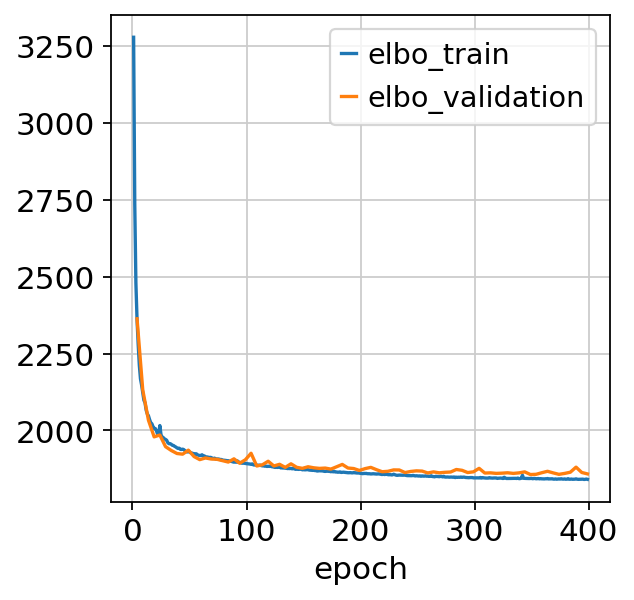

In [21]:
train_elbo = model.history["elbo_train"][1:]
test_elbo = model.history["elbo_validation"]
ax = train_elbo.plot()
test_elbo.plot(ax=ax)

In [ ]:
#adata.write_h5ad("VSN_QCribo_SCVI_hvg5000_hid256_lay2_lat50_zinb_dr025.h5ad")

In [ ]:
#model.save("VSN_QCribo_SCVI_hvg5000_hid256_lay2_lat50_zinb_dr025_model/")

# Loading data / Proceed / Reload

In [ ]:
#adata = sc.read_h5ad('VSN_QCribo_SCVI_hvg5000_hid256_lay2_lat50_zinb_dr025.h5ad')
#adata.obs_names_make_unique

In [22]:
#### Essential recommendation: To replicate the results, please use the provided model.

model = scvi.model.SCVI.load("VSN_QCribo_SCVI_hvg5000_hid256_lay2_lat50_zinb_dr025_model/", adata=adata)

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


INFO     File VSN_QCribo_SCVI_hvg5000_hid256_lay2_lat50_zinb_dr025_model/model.pt already downloaded               


# Proceed

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:24)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:37)
running Leiden clustering
    finished: found 34 clusters and added
    'res_12', the cluster labels (adata.obs, categorical) (0:00:29)
running Leiden clustering
    finished: found 37 clusters and added
    'res_12_22', the cluster labels (adata.obs, categorical) (0:00:00)


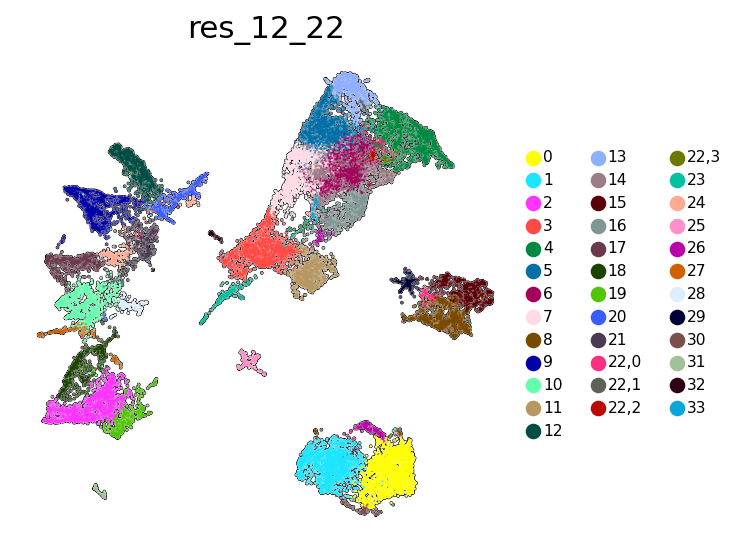

In [23]:
latent = model.get_latent_representation() 
adata.obsm['X_scVI'] = latent
adata.layers['scvi_normalized'] = model.get_normalized_expression(library_size = 1e4)
sc.pp.neighbors(adata, use_rep = 'X_scVI')
sc.tl.umap(adata, min_dist=0.1, spread=1)
sc.tl.leiden(adata, resolution = 1.2, key_added = 'res_12')
sc.tl.leiden(adata, restrict_to=('res_12', ['22']), resolution=0.2, key_added='res_12_22')
sc.pl.umap(adata, color = ['res_12_22'], add_outline=True, ncols=3,
               legend_fontsize=7, legend_fontoutline=0.6,frameon=False, wspace=0.3) 

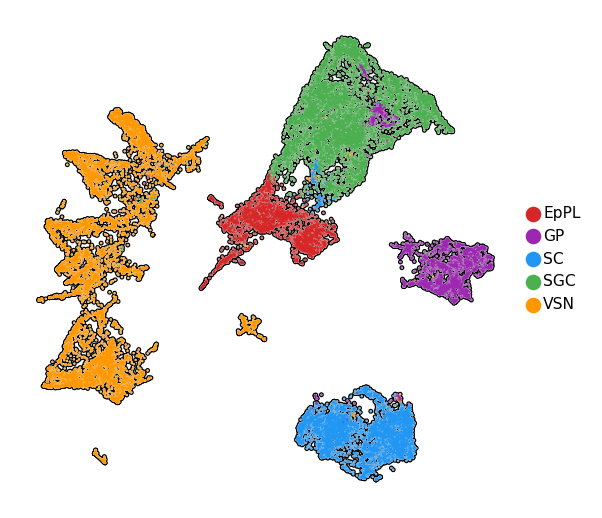

In [24]:
cell_type =  {
"0": 'SC',
"1": 'SC',
"2": 'VSN',
"3": 'EpPL',
"4": 'SGC',
"5": 'SGC',
"6": 'SGC',
"7": 'SGC',
"8": 'GP',
"9": 'VSN',
"10":'VSN',
"11": 'EpPL',
"12": 'VSN',
"13": 'SGC',
"14": 'SGC',
"15": 'GP',
"16": 'SGC',
"17": 'VSN',
"18": 'VSN',
"19": 'VSN',
"20": 'VSN',
"21": 'VSN',
"22,0": 'GP',
"22,1": 'GP',
"22,2": 'GP',
"22,3": 'GP',
"23": 'EpPL',
"24": 'VSN',
"25": 'VSN',
"26": 'SC',
"27": 'VSN',
"28": 'VSN',
"29": 'GP',
"30": 'SC',
"31": 'VSN',
"32":"EpPL",
"33":"SC"
}

adata.obs.res_12_22.map(cell_type)
adata.obs['cell_type'] = adata.obs.res_12_22.map(cell_type)

# Main figure colors
colors =  [
    '#D62728',
    '#9c27b0',
    '#2196f3',
    '#4caf50',
    '#ff9800'
    ]

adata.uns['cell_type_colors'] = colors
sc.pl.umap(adata, color = ['cell_type'], add_outline=True, outline_width=(0.6,0.05),
               legend_fontsize=7, legend_fontoutline=0,frameon=False,title='')#, save='cell_type_umap.svg') 

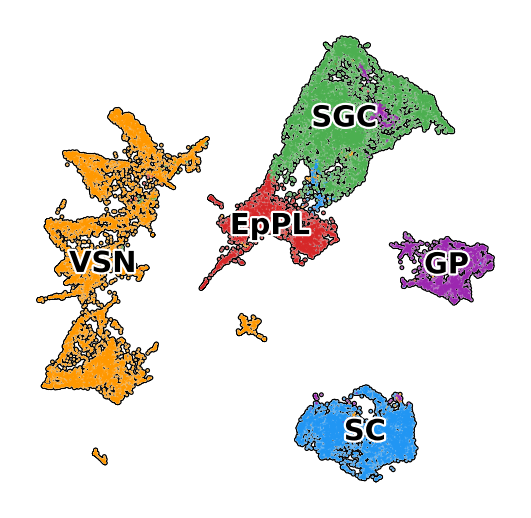

In [25]:
sc.pl.umap(adata, color = ['cell_type'], add_outline=True, outline_width=(0.6,0.05),
               legend_fontsize=13, legend_fontoutline=2,frameon=False,title='', legend_loc ='on data')#, save="Extended_Fig1_1.svg")

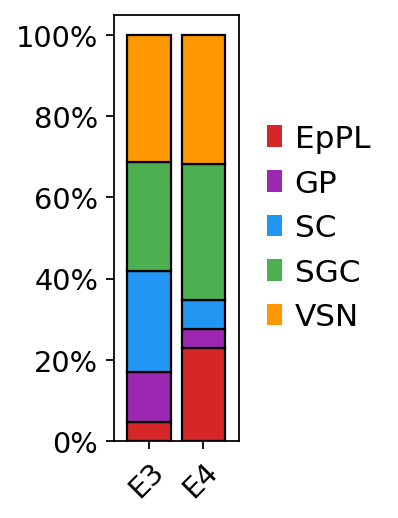

cell_type       EpPL         GP         SC        SGC        VSN
type1                                                           
E3          4.591862  12.236665  25.085911  26.789183  31.296379
E4         22.783659   4.755210   7.153490  33.460139  31.847502
cell_type  EpPL    GP    SC   SGC   VSN
type1                                  
E3          922  2457  5037  5379  6284
E4         2755   575   865  4046  3851


In [26]:
plt.rcParams['figure.figsize'] = (1, 3.5)
tmp = pd.crosstab(adata.obs['type1'], adata.obs['cell_type'], normalize='index').apply(lambda r: r/r.sum()*100, axis=1)

# Define custom width
custom_width = 0.8  # Adjust this value to change the width of the bars

# Define custom colors
custom_colors = colors

# Plotting with custom width
ax = tmp.plot.bar(stacked=True, color=custom_colors, width=custom_width)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14, frameon=False)
plt.title(None)
plt.xlabel(None)  # Removing x-axis label
plt.grid(False)
plt.yticks(fontsize=13)
plt.xticks(rotation=45, rotation_mode='anchor', ha='right', fontsize=13)

# Adding edge lines to the bars
for container in ax.containers:
    plt.setp(container, edgecolor='black')

# Formatting y-axis tick labels
plt.gca().set_yticklabels(['{}%'.format(int(i)) for i in plt.gca().get_yticks()])

#plt.savefig("Figure3_d1.svg", bbox_inches='tight')

plt.show()
print(tmp)
tmp = pd.crosstab(adata.obs['type1'], adata.obs['cell_type'])
print(tmp)

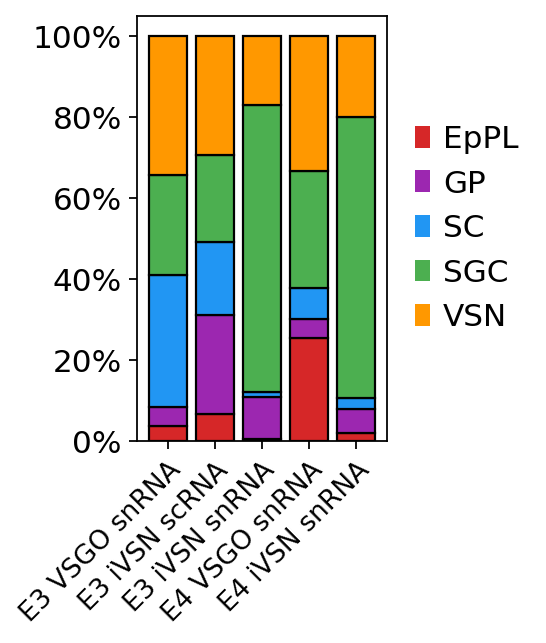

cell_type           EpPL         GP         SC        SGC        VSN
file2                                                               
E3 VSGO snRNA   3.787076   4.555085  32.609463  24.691031  34.357345
E3 iVSN scRNA   6.614045  24.455634  18.004899  21.611323  29.314099
E3 iVSN snRNA   0.498931  10.263721   1.425517  70.848182  16.963649
E4 VSGO snRNA  25.428784   4.595451   7.727442  28.905667  33.342655
E4 iVSN snRNA   1.979472   6.011730   2.639296  69.281525  20.087977
cell_type      EpPL    GP    SC   SGC   VSN
file2                                      
E3 VSGO snRNA   429   516  3694  2797  3892
E3 iVSN scRNA   486  1797  1323  1588  2154
E3 iVSN snRNA     7   144    20   994   238
E4 VSGO snRNA  2728   493   829  3101  3577
E4 iVSN snRNA    27    82    36   945   274


In [27]:
plt.rcParams['figure.figsize'] = (2, 3.5)

file2 = {
'E3_VSGO_frozen_day33' :  'E3 VSGO snRNA'  ,
'E4_VSGO_fresh_day32'     :'E4 VSGO snRNA',
'E3_VSGO_fresh_day32'     :'E3 VSGO snRNA',
'E4_VSGO_frozen_day33'    :'E4 VSGO snRNA',
'iVSN_scRNA_E3_day32'     :'E3 iVSN scRNA',
'iVSN_scRNA_E3_day24'     :'E3 iVSN scRNA',
'iVSN_scRNA_E3_day19'    : 'E3 iVSN scRNA',
'E3_iVSN_frozen_day40'    :'E3 iVSN snRNA',
'E4_iVSN_frozen_day40'   : 'E4 iVSN snRNA',
'iVSN_scRNA_E3_day42' :  'E3 iVSN scRNA'  
            }

adata.obs.file.map(file2)
adata.obs['file2'] = adata.obs.file.map(file2)

tmp2 = pd.crosstab(adata.obs['file2'], adata.obs['cell_type'], normalize='index').apply(lambda r: r/r.sum()*100, axis=1)

# Define custom width
custom_width = 0.8 

# Define custom colors
custom_colors = colors

# Plotting with custom width
ax = tmp2.plot.bar(stacked=True, color=custom_colors, width=custom_width)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14, frameon=False)
plt.title(None)
plt.xlabel(None)  # Removing x-axis label
plt.grid(False)
plt.yticks(fontsize=14)
plt.xticks(rotation=45, rotation_mode='anchor', ha='right', fontsize=12)

# Adding edge lines to the bars
for container in ax.containers:
    plt.setp(container, edgecolor='black')

# Formatting y-axis tick labels
plt.gca().set_yticklabels(['{}%'.format(int(i)) for i in plt.gca().get_yticks()])

#plt.savefig("Figure3_d2.svg", bbox_inches='tight')

plt.show()
print(tmp2)
tmp2 = pd.crosstab(adata.obs['file2'], adata.obs['cell_type'])#, normalize='index').apply(lambda r: r/r.sum()*100, axis=1)
print(tmp2)

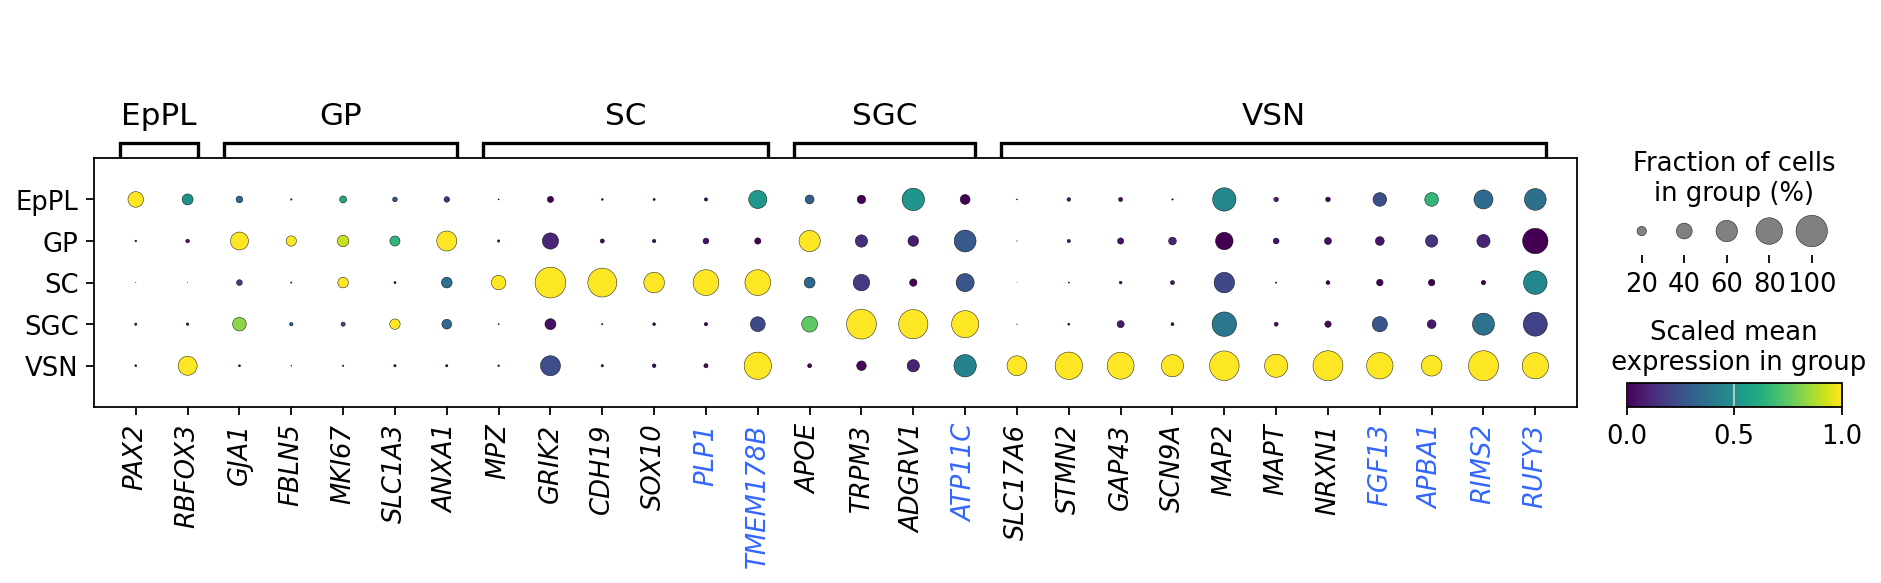

In [28]:
celltype_markers =  {
    "EpPL": ["PAX2", 'RBFOX3'],
    "GP":['GJA1', 'FBLN5', 'MKI67', 'SLC1A3', 'ANXA1'],
    "SC":["MPZ",'GRIK2', 'CDH19', 'SOX10', 'PLP1','TMEM178B'],
    "SGC":['APOE', 'TRPM3', 'ADGRV1', 'ATP11C'],
     "VSN":["SLC17A6", 'STMN2', "GAP43","SCN9A", 'MAP2', 'MAPT', 'NRXN1', 'FGF13', 'APBA1', 'RIMS2','RUFY3' ],
    }

# Create the dotplot
dp = sc.pl.dotplot(adata, 
                  celltype_markers ,
                   groupby='cell_type',
                   standard_scale='var', cmap='viridis',
                   dot_max=1,
                   show=False, dendrogram=False, colorbar_title='Scaled mean\n expression in group')  #return_fig=False)

# Set the size of the figure
plt.gcf().set_size_inches(14, 3.5)  # Set the size of the figure

# Adjust layout to prevent cut labels and save the plot as SVG
plt.subplots_adjust(top=1, bottom=0.3)  # Adjust top and bottom margins to prevent cutting off labels

# Select the Axes object that contains the subplot of interest
ax = dp["mainplot_ax"]

# Loop through ticklabels and make them italic
for l in ax.get_xticklabels():
    l.set_style("italic")
    gene_name = l.get_text()
    # Change settings (e.g. color) of certain ticklabels based on their text (here gene name)
    if gene_name == "TMEM178B":
        l.set_color("#3366FF")
    elif gene_name == "PLP1":
        l.set_color("#3366FF")
    elif gene_name == "ATP11C":
        l.set_color("#3366FF") 
    elif gene_name == "FGF13":
        l.set_color("#3366FF")    
    elif gene_name == "APBA1":
        l.set_color("#3366FF")        
    elif gene_name == "RIMS2":
        l.set_color("#3366FF")   
    elif gene_name == "RUFY3":
        l.set_color("#3366FF")

# Adjust layout to prevent cut labels and save the plot as SVG
plt.tight_layout(pad=5.0)  # Increase padding if needed
#plt.savefig("Figure3_c.svg", format="svg")
